# Temporal Regularization for Control: Toy Example




### Loading Libraries and setting up environment

In [86]:
%reload_ext autoreload

In [87]:
from envs.ring_chain import RingChain
from envs.linear_risk_chain import LinearRiskChain
from agent import AgentNstepSARSA
from agent import AgentSARSA
import numpy as np
import pdb
import matplotlib.pyplot as plt

In [96]:
env = RingChain(horizon=10000)
# env = LinearRiskChain()

## SARSA

#### Implementation in a function

In [118]:
def runSARSA(env, agent, randomStates, updateAllStates=False):
    MSE = []
    Qvals = []
    Qvals.append(agent.Q.copy())
    for ep in range(1):
        state = env.reset()
        action = agent.chooseActionEps(state)
        agent.initializeP(state)
        T = 10000
        for t in range(T):
            state2, reward, done, _ = env.step(action)
            action2 = agent.chooseActionEps(state2)
            agent.updatePolicySARSA(state, action, reward, state2, action2, randomStates)
            MSE.append(np.square(agent.Q[randomStates[0],:] - env.optimalQ[randomStates[0],:]).mean())
            Qvals.append(agent.Q.copy())
            state, action = state2, action2
            if(done):
                break
    return MSE, Qvals

#### Running in loop for different values of beta

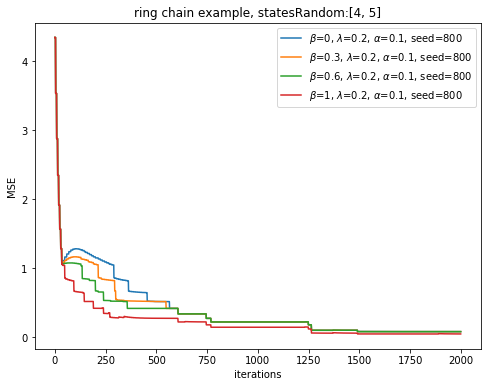

In [123]:
seed = 800
randomStates = [4,5]
alpha = 0.1
plt.figure(figsize=(8,6))
for beta in [0, 0.3, 0.6, 1]:
    for lambd in [0.2]:
        agent = AgentSARSA(env, epsDecay=False, eps=0.05, beta=beta, lambd=lambd, alpha=alpha)
        agent.Q = env.optimalQ.copy()
        np.random.seed(seed)
        agent.Q[randomStates,:] = np.random.rand(len(randomStates),2)*5
        MSE, _ = runSARSA(env, agent, randomStates)
        plt.plot(MSE[:2000], label=r'$\beta$={}, $\lambda$={}, $\alpha$={}, seed={}'.format(beta, lambd, alpha, seed))
plt.legend(), plt.xlabel('iterations'), plt.ylabel('MSE'), plt.title('ring chain example, statesRandom:' + str(randomStates))
plt.show()

#### SARSA implementation (without function)

In [ ]:
agent = AgentSARSA(env, epsDecay=False, eps=0.05, beta=0, alpha=0.05)
for ep in range(5):
    print('ep = ' + str(ep))
    state = env.reset()
    action = agent.chooseActionEps(state)
    agent.initializeP(state)
    T = 10000
    for t in range(T):
        state2, reward, done, _ = env.step(action)
        action2 = agent.chooseActionEps(state2)
        agent.updatePolicySARSA(state, action, reward, state2, action2)
        state, action = state2, action2
        if(done):
            break
            
        if(t%1000==0):
            print('t, eps = ', t, agent.epst)
            plt.plot(agent.Q[:,0], label='action 0')
            plt.plot(agent.Q[:,1], label='action 1')
            plt.xlabel('state'), plt.ylabel('Q(s,a)'),plt.title('Optimal policy at eps = ' + str(agent.epst))
            plt.legend(), plt.show()
            

## N-step SARSA

In [ ]:
# pdb.set_trace()
agent = AgentNstepSARSA(env, no_steps=2, eps=0.5, epsDecay=True)
n = agent.no_steps
for ep in range(10):
    print('ep = ' + str(ep))
    state = env.reset()
    action = agent.chooseActionEps(state)
    agent.state_memory[0], agent.action_memory[0] =  state, action
    T = 10000
    for t in range(T):
        if(t < T):
            state, reward, done, _ = env.step(action)
            agent.state_memory[t+1], agent.reward_memory[t+1] = state, reward
            if(done):
                print("done")
                T = t + 1
            else:
                action = agent.chooseActionEps(state)
                agent.action_memory[t+1] = action
        tau  = t - n + 1
        if(tau>=0):
            rewardsVector = agent.reward_memory[tau+1:np.minimum(tau+n,T)]
            discountingVector = np.power(agent.gamma, np.arange(0, rewardsVector.shape[0]))
            G = np.sum(np.multiply(rewardsVector, discountingVector))
            if(tau + n < T):
                G = G + agent.gamma**n * agent.Q[agent.state_memory[tau + n].astype('int'), agent.action_memory[tau+n].astype('int')]
            agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')] += agent.alpha * (G - agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')])
                
        if(tau==T-1):
            break
            
        if(t%1000==0):
            print('t, eps = ', t, agent.epst)
            plt.plot(agent.Q[:,0], label='action 0')
            plt.plot(agent.Q[:,1], label='action 1')
            plt.xlabel('state'), plt.ylabel('Q(s,a)'),plt.title('Optimal policy at eps = ' + str(agent.epst))
            plt.legend(), plt.show()

n-step SARSA, randomly initialized state

In [ ]:
# pdb.set_trace()
agent = AgentNstepSARSA(env, no_steps=2, eps=0.5, epsDecay=True)
n = agent.no_steps
for ep in range(10):
    print('ep = ' + str(ep))
    state = env.reset()
    action = agent.chooseActionEps(state)
    agent.state_memory[0], agent.action_memory[0] =  state, action
    T = 10000
    for t in range(T):
        if(t < T):
            state, reward, done, _ = env.step(action)
            agent.state_memory[t+1], agent.reward_memory[t+1] = state, reward
            if(done):
                print("done")
                T = t + 1
            else:
                action = agent.chooseActionEps(state)
                agent.action_memory[t+1] = action
        tau  = t - n + 1
        if(tau>=0):
            rewardsVector = agent.reward_memory[tau+1:np.minimum(tau+n,T)]
            discountingVector = np.power(agent.gamma, np.arange(0, rewardsVector.shape[0]))
            G = np.sum(np.multiply(rewardsVector, discountingVector))
            if(tau + n < T):
                G = G + agent.gamma**n * agent.Q[agent.state_memory[tau + n].astype('int'), agent.action_memory[tau+n].astype('int')]
            agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')] += agent.alpha * (G - agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')])
                
        if(tau==T-1):
            break
            
        if(t%1000==0):
            print('t, eps = ', t, agent.epst)
            plt.plot(agent.Q[:,0], label='action 0')
            plt.plot(agent.Q[:,1], label='action 1')
            plt.xlabel('state'), plt.ylabel('Q(s,a)'),plt.title('Optimal policy at eps = ' + str(agent.epst))
            plt.legend(), plt.show()